## KELOMPOK 14

In [1]:

import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb
import threading
from scipy import ndimage
from tqdm import tqdm
from matplotlib import path
import imutils.paths as path


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Kode di atas merupakan contoh impor modul dan pustaka yang umum digunakan dalam pemrosesan gambar dan visualisasi data. import cv2: Modul ini menyediakan fungsi dan alat untuk pemrosesan gambar, termasuk membaca, menulis, dan melakukan operasi pada gambar menggunakan OpenCV. Numpy adalah pustaka Python yang populer untuk komputasi numerik. Digunakan untuk memanipulasi array dan melakukan operasi matematika pada data gambar. Matplotlib adalah pustaka visualisasi data yang umum digunakan dalam Python. Fungsi pyplot di dalamnya digunakan untuk membuat plot grafik dan visualisasi data. import os menyediakan fungsi-fungsi yang memungkinkan interaksi dengan sistem operasi, seperti mengatur path file dan direktori. Pandas adalah pustaka untuk analisis data yang memungkinkan manipulasi dan analisis data struktural. Fungsi pd digunakan untuk membaca dan memanipulasi data dalam format tabular. import math menyediakan fungsi-fungsi matematika yang lebih kompleks, seperti fungsi trigonometri, logaritma. from mpl_toolkits.mplot3d import Axes3D Modul ini menyediakan alat untuk membuat plot grafik tiga dimensi dengan menggunakan Matplotlib. from matplotlib import cm Modul ini menyediakan berbagai map warna yang dapat digunakan dalam visualisasi data. from matplotlib import colors Modul ini berisi berbagai utilitas untuk bekerja dengan warna dalam Matplotlib. from matplotlib.colors import hsv_to_rgb Fungsi ini mengkonversi representasi warna dari ruang warna HSV (Hue, Saturation, Value) ke RGB (Red, Green, Blue). import threading Modul ini menyediakan dukungan untuk multi-threading dalam Python, yang memungkinkan eksekusi paralel dari beberapa tugas secara bersamaan. from scipy import ndimage Modul ini menyediakan fungsi-fungsi untuk pemrosesan citra, seperti filtering, transformasi, dan operasi lainnya. TQDM adalah pustaka yang menyediakan bar kemajuan (progress bar) untuk iterasi loop. from matplotlib import path Modul ini menyediakan alat untuk manipulasi jalur (path) dalam konteks plot grafik. import imutils.paths as path Modul ini menyediakan utilitas untuk memanipulasi jalur file dan direktori pada sistem operasi. from tensorflow.keras.preprocessing.image import load_img Fungsi ini digunakan untuk memuat gambar dari file. from tensorflow.keras.preprocessing.image import img_to_array Fungsi ini digunakan untuk mengubah gambar menjadi array numerik.

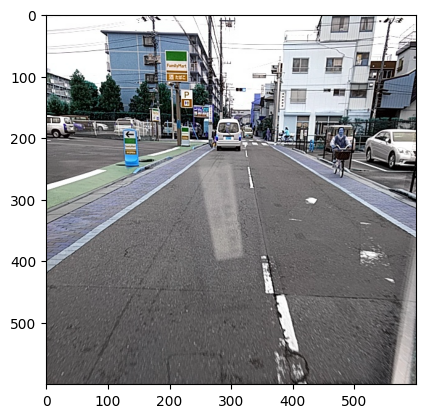

In [23]:
img = cv2.imread("Roadconditions/poor/poor_001.jpg")
img.shape
plt.imshow(img)

Kode di atas digunakan untuk membaca, memperoleh dimensi gambar, dan menampilkan gambar menggunakan OpenCV dan Matplotlib. 

PRE-PROCESSING

In [3]:
# membuat fungsi untuk menyesuaikan dataset agar ukuran dari setiap image sama besar 
# ini membantu dalam mengolah image karena tidak terdapat image yang berbeda ukuran
def crop_resize(img):
    new_size = img.shape[0] if img.shape[0] < img.shape[1] else img.shape[1]

    # ketiga citra landscape
    if img.shape[0] < img.shape[1]:
        starting_w_point = (img.shape[1]-new_size) // 2
        new_image = img[:,  starting_w_point:starting_w_point+new_size, :]

    # ketiga citra potrait
    else:
        starting_h_point = (img.shape[1]-new_size) // 2
        new_image = img[starting_h_point:starting_h_point+new_size, :, :]

    new_image = cv2.resize(new_image, (255, 255), interpolation=cv2.INTER_AREA)
    return new_image

Kode di atas mengimplementasikan fungsi crop_resize yang memiliki tujuan untuk memotong dan mengubah ukuran gambar agar memiliki ukuran persegi dengan dimensi 255x255 piksel.Setelah proses pemotongan selesai, gambar yang telah dipotong akan diubah ukurannya menjadi 255x255 piksel menggunakan fungsi cv2.resize. Fungsi ini menerima argumen gambar yang akan diubah ukurannya, dimensi baru yang diinginkan (255, 255), dan metode interpolasi yang digunakan. Hasil akhirnya akan menjadi gambar persegi dengan ukuran 255x255 piksel

In [4]:
from tensorflow.keras import layers
import tensorflow as tf

# utilitis
target = 500
dataset_dir = 'Roadconditions'
kernel = np.ones((5,5),np.float32)/25


def mk_new_dir(parent):
    os.mkdir(parent)

    for label in os.listdir(f'{dataset_dir}'):
        os.mkdir(f'{parent}/{label}')


def count_dataset(parent):
    for label in os.listdir(parent):
        label_dir = f'{parent}/{label}'
        print(f'{label}:{len (os.listdir(label_dir)) }')


# data augmentation
# tujuan kami menggunakan augmentasi yaitu untuk memperbanyak dataset yang ada agar 
# nantinya pengetesan dilakukan ke banyak data itu akan menyebabkan proses spesifikasi akan lebih akurat
def data_augmentation(label, multiplier):
    print('Processing '+label+' thread started')
    data_aug = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip(
            "horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='constant', fill_value=255),
        layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, fill_mode='constant', fill_value=255)
    ])
    # add image to batch
    images = []
    filenames = []
    for filename in os.listdir('Roadconditions/'+label):
        img_dir = f'Roadconditions/{label}/{filename}'
        img_pil = load_img(img_dir)
        img = img_to_array(img_pil)
        img = img.astype(np.uint8)

        # crop and resize dengan memanggil fungsi crop_resize yang telah dibuat sebelumnya
        img = crop_resize(img)

        # masking untuk memperbaiki citra yang memiliki kualitas yang kurang baik
        mask = np.zeros(img.shape[:2], dtype="uint8")
        cv2.rectangle(mask, (0, 90), (290, 450), 255, -1)
        img = cv2.bitwise_and(img, img, mask=mask)

        # median filtering digunakan untuk menghilangkan noise noise yang ada pada gambar
        img = cv2.filter2D(img,-1,kernel)

        # gaussian blur digunakan agar dapat memperjelas crack pada ban
        img = cv2.GaussianBlur(img, (7, 7), 0)
        

        images.append(img)
        filenames.append(filename)


    images = np.array(images)
    print(images.shape)

    for i in range(multiplier):
        aug_images = data_aug(images)
        for j in range(len(aug_images)):
            tf.keras.utils.save_img(
                'Roadconditions/'+label+'/'+str(i)+'_' + filenames[j], aug_images[j])

Kode di atas memiliki beberapa fungsi dan implementasi terkait pemrosesan dataset gambar untuk tujuan data augmentation. from tensorflow.keras import layers dan import tensorflow as tf merupakan Baris ini mengimpor modul dan fungsi yang diperlukan dari TensorFlow untuk membangun dan melatih model neural network. Dalam fungsi ini, gambar diambil dari direktori gambar dengan label yang diberikan, kemudian diproses dengan fungsi crop_resize untuk memotong dan mengubah ukuran menjadi persegi dengan dimensi 255x255 piksel. Selanjutnya, gambar juga dikenakan masking, filtering median, dan Gaussian blur untuk meningkatkan kualitas dan kejelasan citra. Setelah itu, data augmentation diterapkan pada gambar menggunakan objek data_aug yang telah dibuat sebelumnya. Hasil dari augmentasi tersebut disimpan dalam direktori yang sama dengan gambar asli.

In [5]:
import _thread as thread
directories = [label for label in os.listdir('Roadconditions') if not label.startswith('.DS_Store')]
for label in directories:
    mult = target//len(os.listdir('Roadconditions/'+label)) + 1
    try:
        data_augmentation(label, mult)
    except Exception as e:
        print('error at thread ', label)
        print(e)

Processing good thread started
(845, 255, 255, 3)
Processing poor thread started
(396, 255, 255, 3)
Processing satisfactory thread started
(515, 255, 255, 3)
Processing very_poor thread started
(318, 255, 255, 3)


Kode di atas berfungsi untuk melakukan data augmentation pada setiap label dalam dataset gambar. melakukan data augmentation pada setiap label dalam dataset gambar. Hal ini dilakukan dengan menghitung faktor penggandaan yang sesuai untuk setiap label dan memanggil fungsi data_augmentation untuk menerapkan augmentasi pada label tersebut.

In [6]:
def insertGambar(folder):
    images = []
    filenames = []
    datalabel = []
    for label in os.listdir(folder):
        datalabel.append(label)
        print(label)
        for filename in os.listdir("Roadconditions/"+label):
            img = cv2.imread(os.path.join("Roadconditions/"+label,filename))
            filenames.append(filename)
            if img is not None:
                images.append(img)
    return images, filenames, label

images, filenames, label = insertGambar("Roadconditions")

good
poor
satisfactory
very_poor


Kode di atas mengimplementasikan fungsi insertGambar yang digunakan untuk mengumpulkan gambar-gambar dari folder yang diberikan. kemudian mengumpulkan gambar-gambar dari folder "Roadconditions" dan mengembalikan list images yang berisi semua gambar, list filenames yang berisi semua nama file gambar, dan label yang merupakan label terakhir yang ditemukan.

In [7]:
PATH = 'Roadconditions'
imagePaths = sorted(list(path.list_images(PATH)))

Kode di atas digunakan untuk mengumpulkan path atau biasa disebut alamat file dari semua gambar dalam direktori yang diberikan. setelah baris ini dieksekusi, imagePaths akan berisi daftar path dari semua gambar yang ada dalam direktori 'Roadconditions'. Path-path ini nantinya dapat digunakan untuk membaca dan memproses setiap gambar secara berurutan.

In [8]:
data = []
for i in tqdm(imagePaths,desc="load"):
    imgg=cv2.imread (i)
    img = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)
    a = cv2.resize (img, (256, 256))
    data.append (a)

load: 100%|██████████| 4862/4862 [00:33<00:00, 147.18it/s] 


GLCM

Kode di atas digunakan untuk membaca dan memproses gambar-gambar yang diidentifikasi oleh path-path dalam imagePaths. setelah kode ini dieksekusi, list data akan berisi gambar-gambar yang telah diubah menjadi grayscale dan diresize menjadi ukuran 256x256 piksel. Gambar-gambar ini siap untuk digunakan dalam tahap selanjutnya, seperti pemrosesan atau analisis lebih lanjut.

In [9]:
def derajat0 (img):
    max = np.max(img)
    imgTmp=np.zeros([max+1,max+1])
    for i in range (len(img)):
        for j in range (len(img[i])-1):
            imgTmp[img[i,j],img[i,j+1]] += 1
            
    data= imgTmp+np.transpose(imgTmp)
    tmp=np.sum(data)
            
    for i in range (len (data)):
        for j in range (len (data)):
            data[i,j]/=tmp
    return data

Kode di atas mengimplementasikan fungsi derajat0 yang digunakan untuk menghitung matriks distribusi derajat nol (degree-zero distribution matrix) dari suatu gambar. fungsi derajat0 akan menghitung dan menghasilkan matriks distribusi derajat nol dari gambar yang diberikan. Matriks ini memberikan informasi tentang hubungan distribusi nilai piksel yang berdekatan dalam gambar

In [10]:
def derajat45 (img):
    max = np.max(img)
    imgTmp=np.zeros([max+1,max+1])
    for i in range (len (img)-1):
        for j in range (len (img[i])-1):
            imgTmp[img[i+1,j],img[i,j+1]] += 1
            
    data= imgTmp+np.transpose(imgTmp)
    tmp=np.sum(data)
    
    for i in range (len (data)):
        for j in range (len (data)):
            data[i,j]/=tmp
    return data

Kode di atas mengimplementasikan fungsi derajat45 yang digunakan untuk menghitung matriks distribusi derajat 45 derajat (degree-45 distribution matrix) dari suatu gambar fungsi derajat45 akan menghitung dan menghasilkan matriks distribusi derajat 45 derajat dari gambar yang diberikan. Matriks ini memberikan informasi tentang hubungan distribusi nilai piksel pada garis 45 derajat dalam gambar tersebut.

In [11]:
def derajat90 (img):
    max = np.max(img)
    imgTmp=np.zeros([max+1,max+1])
    for i in range (len (img)-1):
        for j in range (len (img[i])):
            imgTmp[img[i+1,j],img[i,j]] += 1
            
    data= imgTmp+np.transpose(imgTmp)
    tmp=np.sum(data)
            
    for i in range (len (data)):
        for j in range (len (data)):
            data[i,j]/=tmp
    return data

Kode di atas mengimplementasikan fungsi derajat90 yang digunakan untuk menghitung matriks distribusi derajat 90 derajat (degree-90 distribution matrix) dari suatu gambar.  fungsi derajat90 akan menghitung dan menghasilkan matriks distribusi derajat 90 derajat dari gambar yang diberikan. Matriks ini memberikan informasi tentang hubungan distribusi nilai piksel pada garis vertikal dalam gambar

In [12]:
def derajat135 (img):
    max = np.max(img)
    imgTmp=np.zeros([max+1,max+1])
    for i in range (len (img)-1):
        for j in range (len (img[i])-1):
            imgTmp[img[i,j],img[i+1,j+1]] += 1
            
    data= imgTmp+np.transpose(imgTmp)
    tmp=np.sum(data)
            
    for i in range (len (data)):
        for j in range (len (data)):
            data[i,j]/=tmp
    return data

Kode di atas mengimplementasikan fungsi derajat135 yang digunakan untuk menghitung matriks distribusi derajat 135 derajat (degree-135 distribution matrix) dari suatu gambar.  fungsi derajat135 akan menghitung dan menghasilkan matriks distribusi derajat 135 derajat dari gambar yang diberikan. Matriks ini memberikan informasi tentang hubungan distribusi nilai piksel pada garis diagonal 135 derajat dalam gambar.

In [13]:
jumlah = 2000
image = imagePaths[:jumlah]
hasil=[]

for i in tqdm (range(len(image)), desc='glcm'):
    dat=[]
    dat.append(derajat0 (data[i]))
    dat.append(derajat45 (data[i]))
    dat.append(derajat90 (data[i]))
    dat.append(derajat135 (data[i]))
    hasil.append(dat)

glcm: 100%|██████████| 2000/2000 [06:05<00:00,  5.47it/s]


Kode di atas berfungsi untuk menghitung matriks distribusi derajat (GLCM - Gray Level Co-occurrence Matrix) dari sejumlah gambar yang dipilih. kode di atas akan menghitung matriks GLCM dengan berbagai derajat untuk setiap gambar yang dipilih. Hasil perhitungan tersebut akan disimpan dalam list hasil.

In [14]:
def contras (data):
    contras=0
    for i in range (len (data)):
        for j in range (len (data)):
            contras+=data[i,j]*pow(i-j,2)
    return contras

pada kode ini berfungsi untuk menghitung kontras dari sebuah matriks data. Kontras merupakan salah satu metrik yang digunakan untuk mengukur variasi intensitas dalam suatu gambar. Langkah-langkah yang dilakukan oleh fungsi ini meliputi: pertama, variabel contrast diinisialisasi sebagai nol. Selanjutnya, dilakukan iterasi melalui setiap elemen dalam matriks data menggunakan nested loop. Pada setiap iterasi, kontribusi dari elemen tersebut terhadap kontras dihitung dengan mengalikan nilai elemen dengan kuadrat selisih antara indeks baris dan indeks kolom. Hasil kontribusi dari setiap elemen ditambahkan ke variabel contrast. Setelah selesai iterasi, nilai contrast yang merupakan akumulasi kontribusi dari seluruh elemen dalam matriks dikembalikan sebagai output fungsi. Dengan menggunakan fungsi contrast(data), kita dapat menghitung nilai kontras dari matriks data yang dapat digunakan sebagai fitur dalam analisis citra atau pengolahan gambar.

In [15]:
def entropy (data):
    entro=0
    for i in range (len (data)):
        for j in range (len (data)):
            if data[i,j] > 0.0:
                entro += -(data[i,j] * math.log(data[i,j]))
    return entro

pada kode ini untuk menghitung entropy dari sebuah matriks data. Entropy merupakan salah satu metrik yang digunakan untuk mengukur tingkat ketidakpastian atau kompleksitas distribusi probabilitas dari suatu variabel acak. Langkah-langkah yang dilakukan oleh fungsi ini adalah sebagai berikut: pertama, variabel entropy diinisialisasi sebagai nol. Selanjutnya, dilakukan iterasi melalui setiap elemen dalam matriks data menggunakan nested loop. Pada setiap iterasi, jika nilai elemen tersebut lebih besar dari nol, kontribusinya terhadap entropy dihitung dengan mengalikan nilai elemen dengan logaritma basis 10 dari nilai elemen tersebut yang kemudian dikalikan dengan minus satu. Hasil kontribusi dari setiap elemen yang memenuhi kondisi tersebut ditambahkan ke variabel entropy. Setelah selesai iterasi, nilai entropy yang merupakan akumulasi kontribusi dari seluruh elemen dalam matriks dikembalikan sebagai output fungsi. Dengan menggunakan fungsi entropy(data), kita dapat menghitung nilai entropy dari matriks data yang dapat digunakan sebagai fitur dalam analisis citra atau pengolahan gambar.

In [16]:
def homogentitas (data):
    homogen=0
    for i in range (len (data)):
        for j in range (len (data)):
            homogen+=data[i,j]*(1+(pow(i-j,2)))
    return homogen

untuk menghitung homogenetitas dari sebuah matriks data. Homogenetitas merupakan salah satu metrik yang digunakan untuk mengukur tingkat keseragaman atau keterhubungan intensitas dalam suatu gambar. Langkah-langkah yang dilakukan oleh fungsi ini meliputi: pertama, variabel homogenetitas diinisialisasi sebagai nol. Selanjutnya, dilakukan iterasi melalui setiap elemen dalam matriks data menggunakan nested loop. Pada setiap iterasi, kontribusi dari elemen tersebut terhadap homogenetitas dihitung dengan membagi nilai elemen dengan penjumlahan 1 dan kuadrat selisih antara indeks baris dan indeks kolom. Hasil kontribusi dari setiap elemen ditambahkan ke variabel homogenetitas. Setelah selesai iterasi, nilai homogenetitas yang merupakan akumulasi kontribusi dari seluruh elemen dalam matriks dikembalikan sebagai output fungsi. Dengan menggunakan fungsi homogenetitas(data), kita dapat menghitung nilai homogenetitasm dari matriks data yang dapat digunakan sebagai fitur dalam analisis citra atau pengolahan gambar.

In [17]:
def energi (data):
    ener=0
    for i in range (len (data)):
        for j in range (len (data)):
            ener += data[i,j]**2
    return ener

pada kode ini untuk menghitung energy (energi) dari sebuah matriks data. Energy merupakan metrik yang mengukur jumlah energi atau kekuatan distribusi intensitas dalam suatu gambar. Langkah-langkah yang dilakukan oleh fungsi ini adalah sebagai berikut: pertama, variabel energy diinisialisasi sebagai nol. Selanjutnya, dilakukan iterasi melalui setiap elemen dalam matriks data menggunakan nested loop. Pada setiap iterasi, kontribusi dari elemen tersebut terhadap energy dihitung dengan mengkuadratkan nilai elemen dan menambahkannya ke variabel energy. Setelah selesai iterasi, nilai energy yang merupakan akumulasi kontribusi kuadrat dari seluruh elemen dalam matriks dikembalikan sebagai output fungsi. Dengan menggunakan fungsi energy(data), kita dapat menghitung nilai energy dari matriks data yang dapat digunakan sebagai fitur dalam analisis citra atau pengolahan gambar.

In [18]:
def pearson_correlation(data):
    mean1 = np.mean(data)
    std = np.std(data)
    
    covariance = np.cov(data)[0, 1]
    correlation = covariance / (std)
    
    return correlation

pada kode ini untuk menghitung korelasi (correlation) dari sebuah matriks data. Korelasi mengukur tingkat hubungan linier antara dua variabel, dalam hal ini intensitas piksel dalam gambar. Fungsi ini melakukan iterasi melalui setiap elemen dalam matriks data dan menghitung kontribusi terhadap korelasi dengan mengalikan koordinat (i, j) dengan nilai elemen data[i][j]. Selain itu, fungsi juga menghitung mean dari variabel i dan j, serta menghitung standard deviation dari variabel i dan j. Setelah itu, dilakukan pengecekan untuk menghindari pembagian dengan nol saat perhitungan korelasi. Jika standard deviation tidak nol, maka dilakukan perhitungan korelasi dengan mengurangi perkalian mean dari i dan j dari korelasi dan membaginya dengan perkalian standard deviation dari i dan j. Hasil korelasi kemudian dikembalikan sebagai output dari fungsi.

In [19]:
data0=[]
x=['0','45','90','135']
hasil1=[]
for j in tqdm (range(len(hasil)),desc="ektraksi"):
    da=[]
    da.append(imagePaths[j])
    for i in hasil[j]:
        dx = energi (i)
        da.append(dx)

        dh = homogentitas (i)
        da.append(dh)

        den = entropy (i)
        da.append(den)

        dco = contras (i)
        da.append(dco)
        
        dpeco = pearson_correlation(i)
        da.append(dpeco)

    hasil1.append(da)


ektraksi: 100%|██████████| 2000/2000 [12:50<00:00,  2.60it/s]


Kode di atas ditulis dalam bahasa pemrograman Python dan berisi perulangan yang mengiterasi nilai dari suatu urutan. Perulangan ini menambahkan beberapa nilai ke dalam sebuah list dan kemudian menambahkan list tersebut ke dalam list lainnya. Fungsi tqdm digunakan untuk menampilkan progress bar saat perulangan berjalan. Fungsi range() menghasilkan urutan bilangan bulat dari 0 hingga panjang dari variabel hasil. Fungsi tqdm() digunakan untuk menampilkan progress bar saat perulangan berjalan. Parameter desc digunakan untuk memberikan deskripsi pada progress bar. Di dalam perulangan, list baru da dibuat dan nilai imagePaths[j] ditambahkan ke dalamnya. Kemudian, untuk setiap nilai dalam hasil[j], fungsi energi(), homogentitas(), entropy(), contras(), dan pearson_correlation() dipanggil dengan i sebagai argumen. Nilai yang dikembalikan kemudian ditambahkan ke dalam list da. Terakhir, list da ditambahkan ke dalam list hasil1

In [20]:
headerssss=['path','energi0','homogenitas0','entropy0','contras0', 'pearson_correlation0'
           ,'energi45','homogenitas45','entropy45','contras45', 'pearson_correlation45'
           ,'energi90','homogenitas90','entropy90','contras90', 'pearson_correlation90'
           ,'energi135','homogenitas135','entropy135','contras135', 'pearson_correlation135']
df = pd.DataFrame(hasil1, columns=headerssss)

Kode di atas menggunakan pustaka Pandas untuk membuat DataFrame dari list hasil1 dengan mengatur nama kolom menggunakan list headerssss. terdapat inisialisasi variabel headerssss yang berisi nama-nama kolom yang akan digunakan dalam DataFrame yang akan dibuat. Nama kolom tersebut disusun dalam bentuk list dengan urutan yang sesuai dengan data yang akan dimasukkan. fungsi pd.DataFrame(). DataFrame ini menggunakan data dari hasil1 dan kolom-kolomnya diberikan nama sesuai dengan list headerssss. DataFrame df akan berisi data dari hasil1 dengan nama kolom yang telah ditentukan. DataFrame ini dapat digunakan untuk analisis data lebih lanjut atau disimpan dalam format file seperti CSV.

In [21]:
# df['labels'] = labels
df

,path,energi0,homogenitas0,entropy0,contras0,pearson_correlation0,energi45,homogenitas45,entropy45,contras45,...,energi90,homogenitas90,entropy90,contras90,pearson_correlation90,energi135,homogenitas135,entropy135,contras135,pearson_correlation135
0,Roadconditions\good\0_good_001.JPG,0.058200,89.620741,5.885801,88.620741,0.003624,0.056350,142.760569,5.844826,141.760569,...,0.059177,110.463741,5.681740,109.463741,0.004092,0.055615,233.067774,6.085566,232.067774,0.005465
1,Roadconditions\good\0_good_002.JPG,0.067320,160.929121,5.527720,159.929121,0.003959,0.065606,155.707282,5.535477,154.707282,...,0.068933,56.536091,5.391491,55.536091,0.002692,0.065114,252.286321,5.738927,251.286321,0.004790
2,Roadconditions\good\0_good_003.JPG,0.096594,85.031097,4.700341,84.031097,0.001707,0.092078,287.951250,5.231214,286.951250,...,0.094559,206.262852,5.132105,205.262852,0.001547,0.092233,292.700807,5.269198,291.700807,0.002657
3,Roadconditions\good\0_good_004.JPG,0.064762,106.323422,6.122910,105.323422,0.004396,0.063215,227.919308,6.320485,226.919308,...,0.066146,97.638894,5.924541,96.638894,0.002782,0.063732,163.865606,6.172661,162.865606,0.004678
4,Roadconditions\good\0_good_005.JPG,0.087830,112.119899,5.459099,111.119899,0.002610,0.082984,332.477386,6.060739,331.477386,...,0.085197,216.762132,5.955016,215.762132,0.007006,0.083038,323.323722,6.067663,322.323722,0.007548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Roadconditions\poor\0_poor_306.jpg,0.067043,135.045021,5.615700,134.045021,0.001853,0.064069,243.431819,5.959576,242.431819,...,0.066312,115.986183,5.771473,114.986183,0.003088,0.064379,242.613303,5.915238,241.613303,0.003347
1996,Roadconditions\poor\0_poor_307.jpg,0.069073,122.959819,5.722214,121.959819,0.002671,0.066670,238.797570,6.003259,237.797570,...,0.069293,100.509252,5.714526,99.509252,0.002929,0.067277,187.374333,5.793993,186.374333,0.003158
1997,Roadconditions\poor\0_poor_308.jpg,0.074108,177.134298,6.160080,176.134298,0.002186,0.071513,299.845275,6.322251,298.845275,...,0.073042,156.047932,6.200961,155.047932,0.003320,0.071089,349.436201,6.451766,348.436201,0.003486
1998,Roadconditions\poor\0_poor_309.jpg,0.074438,98.286581,5.512189,97.286581,0.002779,0.071898,203.791849,5.652366,202.791849,...,0.073717,132.331311,5.609317,131.331311,0.002389,0.071116,231.396709,5.826084,230.396709,0.003363


Kode di atas menambahkan kolom baru dengan nama 'labels' ke dalam DataFrame df yang telah dibuat sebelumnya. Kolom ini diisi dengan data yang berasal dari variabel labels. df['labels'] = labels. Ini adalah sintaks untuk menambahkan kolom baru dengan nama 'labels' ke dalam DataFrame df dan merujuk pada kolom baru yang akan ditambahkan. Dalam hal ini, kolom baru tersebut bernama 'labels'. Variabel labels diasumsikan telah didefinisikan sebelumnya dan berisi data yang sesuai dengan jumlah baris dalam DataFrame df. kolom baru 'labels' akan ditambahkan ke DataFrame df dan diisi dengan data yang berasal dari variabel labels. Hasilnya akan ditampilkan saat df dipanggil pada baris terakhir.

In [25]:
df.to_csv(r'Hasil_GLCM.csv', index=False)

Kode di atas digunakan untuk menyimpan DataFrame df ke dalam file CSV dengan nama "Hasil_GLCM.csv". df.to_csv() adalah metode pada objek DataFrame yang digunakan untuk menyimpan DataFrame ke dalam file CSV. Dengan menjalankan pernyataan df.to_csv(r'Hasil_GLCM.csv', index=False), DataFrame df akan disimpan dalam file CSV dengan nama "Hasil_GLCM.csv" tanpa menyertakan indeksnya. File CSV tersebut akan berisi data dari DataFrame yang dapat dibaca atau digunakan untuk analisis data lebih lanjut.